# Ottawa Stacking Ensemble Model for Air Quality Prediction

**Location:**
- Traffic Station: HWY-417 (Longitude: -75.67392, Latitude: 45.41684)
- Air Quality Station: RIDEAU ST./WURTEMBURG ST.

**Objective:**
Build a stacking ensemble that combines XGBoost, Random Forest, and GAM predictions to improve NO₂ forecasting accuracy.

**Model Architecture:**
- Base Models: XGBoost, Random Forest, GAM
- Meta-Learner: Ridge Regression
- Benefits: Combines strengths of different models, often beats individual models

In [1]:
# !pip install xgboost
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.base import clone
from xgboost import XGBRegressor
from pygam import LinearGAM, s, f

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Preparation

Load air quality, traffic, and weather data for Ottawa.

In [3]:
print("Loading Ottawa processed data...")
print("="*60)

['Station', 'Date', 'NO2_Mean', 'Traffic_Count', 'Temp', 'Precip','Wind_Gust', 'Wind_Dir']

# Load pre-processed Ottawa data (created by prepare_ottawa_data.py)
df = pd.read_csv('../data/data_clean/cleaned_data_ottawa_downtown.csv')
df['Date'] = pd.to_datetime(df['Date'])
# df['NO2_Mean'].mean()
# df['Traffic_Count'].mean()

df.rename(columns={"Temp": "Mean_Temp"}, inplace=True)

print(f"Merged data shape: {df.shape}")
print(f"\nDate range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nMissing values:\n{df.isnull().sum()}")

# traffic_data = pd.read_csv('../data/traffic/ottawa_traffic_processed.csv')
# traffic_data['Date'] = pd.to_datetime(traffic_data['Date'])

# weather_data = pd.read_csv('../data/weather/ottawa_weather_processed.csv')
# weather_data['Date'] = pd.to_datetime(weather_data['Date'])

# print(f"\n✓ Air Quality Data Shape: {aq_data.shape}")
# print(f"  Date range: {aq_data['Date'].min()} to {aq_data['Date'].max()}")
# print(f"  NO2 mean: {aq_data['NO2_Mean'].mean():.2f} ppb")

# print(f"\n✓ Traffic Data Shape: {traffic_data.shape}")
# print(f"  Date range: {traffic_data['Date'].min()} to {traffic_data['Date'].max()}")
# print(f"  Traffic mean: {traffic_data['Traffic_Count'].mean():.0f} vehicles/day")

# print(f"\n✓ Weather Data Shape: {weather_data.shape}")
# print(f"  Date range: {weather_data['Date'].min()} to {weather_data['Date'].max()}")
# print(f"  Mean temperature: {weather_data['Mean_Temp'].mean():.1f}°C")

print("\n" + "="*60)
print("✅ All Ottawa data loaded successfully!")
print(df.head())
print("="*60)

Loading Ottawa processed data...
Merged data shape: (1064, 8)

Date range: 2022-02-02 00:00:00 to 2024-12-31 00:00:00

Missing values:
Station          0
Date             0
NO2_Mean         0
Traffic_Count    0
Mean_Temp        0
Precip           0
Wind_Gust        0
Wind_Dir         0
dtype: int64

✅ All Ottawa data loaded successfully!
           Station       Date   NO2_Mean  Traffic_Count  Mean_Temp  Precip  \
0  Ottawa Downtown 2022-02-02  22.479167            540       -1.2     3.7   
1  Ottawa Downtown 2022-02-03   5.308333            502       -5.8     2.3   
2  Ottawa Downtown 2022-02-04   5.083333            370      -12.4     0.8   
3  Ottawa Downtown 2022-02-05   8.308333            328      -17.7     0.0   
4  Ottawa Downtown 2022-02-06  16.754167            374      -14.8     0.2   

   Wind_Gust    Wind_Dir  
0  39.008756  125.049957  
1  36.000000  330.000000  
2  33.000000   10.000000  
3  35.000000  270.000000  
4  41.044838  171.275005  


## 2. Data Processing and Feature Engineering

In [ ]:
# # Convert date columns to datetime
# aq_data['Date'] = pd.to_datetime(aq_data['Date'])
# traffic_data['Date'] = pd.to_datetime(traffic_data['Date'])
# weather_data['Date'] = pd.to_datetime(weather_data['Date'])

# # Merge datasets
# df = aq_data.merge(traffic_data[['Date', 'Traffic_Count']], on='Date', how='inner')
# df = df.merge(weather_data[['Date', 'Mean_Temp', 'Precip', 'Wind_Gust', 'Wind_Dir']], 
#               on='Date', how='inner')

# print(f"Merged data shape: {df.shape}")
# print(f"\nDate range: {df['Date'].min()} to {df['Date'].max()}")
# print(f"\nMissing values:\n{df.isnull().sum()}")

# # Display first few rows
# df.head()


# print(df_clean.columns)

In [6]:
# Feature Engineering
print("Creating temporal and interaction features...")

# Temporal features
df['Day_of_Week'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df['Date'].dt.month
df['Day_of_Year'] = df['Date'].dt.dayofyear
df['Is_Weekend'] = (df['Day_of_Week'] >= 5).astype(int)
df['Season'] = df['Month'] % 12 // 3 + 1  # 1=Winter, 2=Spring, 3=Summer, 4=Fall

# Lag features (previous day's NO2 and traffic)
df['NO2_Lag_1'] = df['NO2_Mean'].shift(1)
df['NO2_Lag_7'] = df['NO2_Mean'].shift(7)
df['Traffic_Lag_1'] = df['Traffic_Count'].shift(1)

# Rolling averages
df['NO2_Rolling_7'] = df['NO2_Mean'].rolling(window=7, min_periods=1).mean()
df['Traffic_Rolling_7'] = df['Traffic_Count'].rolling(window=7, min_periods=1).mean()
df['Temp_Rolling_7'] = df['Mean_Temp'].rolling(window=7, min_periods=1).mean()

# Interaction features
df['Traffic_x_Wind'] = df['Traffic_Count'] * df['Wind_Gust']
df['Temp_x_Traffic'] = df['Mean_Temp'] * df['Traffic_Count']

# Wind components (N-S and E-W)
df['Wind_NS'] = df['Wind_Gust'] * np.cos(np.radians(df['Wind_Dir']))
df['Wind_EW'] = df['Wind_Gust'] * np.sin(np.radians(df['Wind_Dir']))

# Drop rows with NaN values created by lag/rolling features
df_clean = df.dropna().reset_index(drop=True)

print(f"\nClean data shape: {df_clean.shape}")
print(f"Features created: {df_clean.shape[1]} columns")
print(f"\nFeature list:")
print(df_clean.columns.tolist())

Creating temporal and interaction features...

Clean data shape: (1057, 23)
Features created: 23 columns

Feature list:
['Station', 'Date', 'NO2_Mean', 'Traffic_Count', 'Mean_Temp', 'Precip', 'Wind_Gust', 'Wind_Dir', 'Day_of_Week', 'Month', 'Day_of_Year', 'Is_Weekend', 'Season', 'NO2_Lag_1', 'NO2_Lag_7', 'Traffic_Lag_1', 'NO2_Rolling_7', 'Traffic_Rolling_7', 'Temp_Rolling_7', 'Traffic_x_Wind', 'Temp_x_Traffic', 'Wind_NS', 'Wind_EW']


## 3. Exploratory Data Analysis

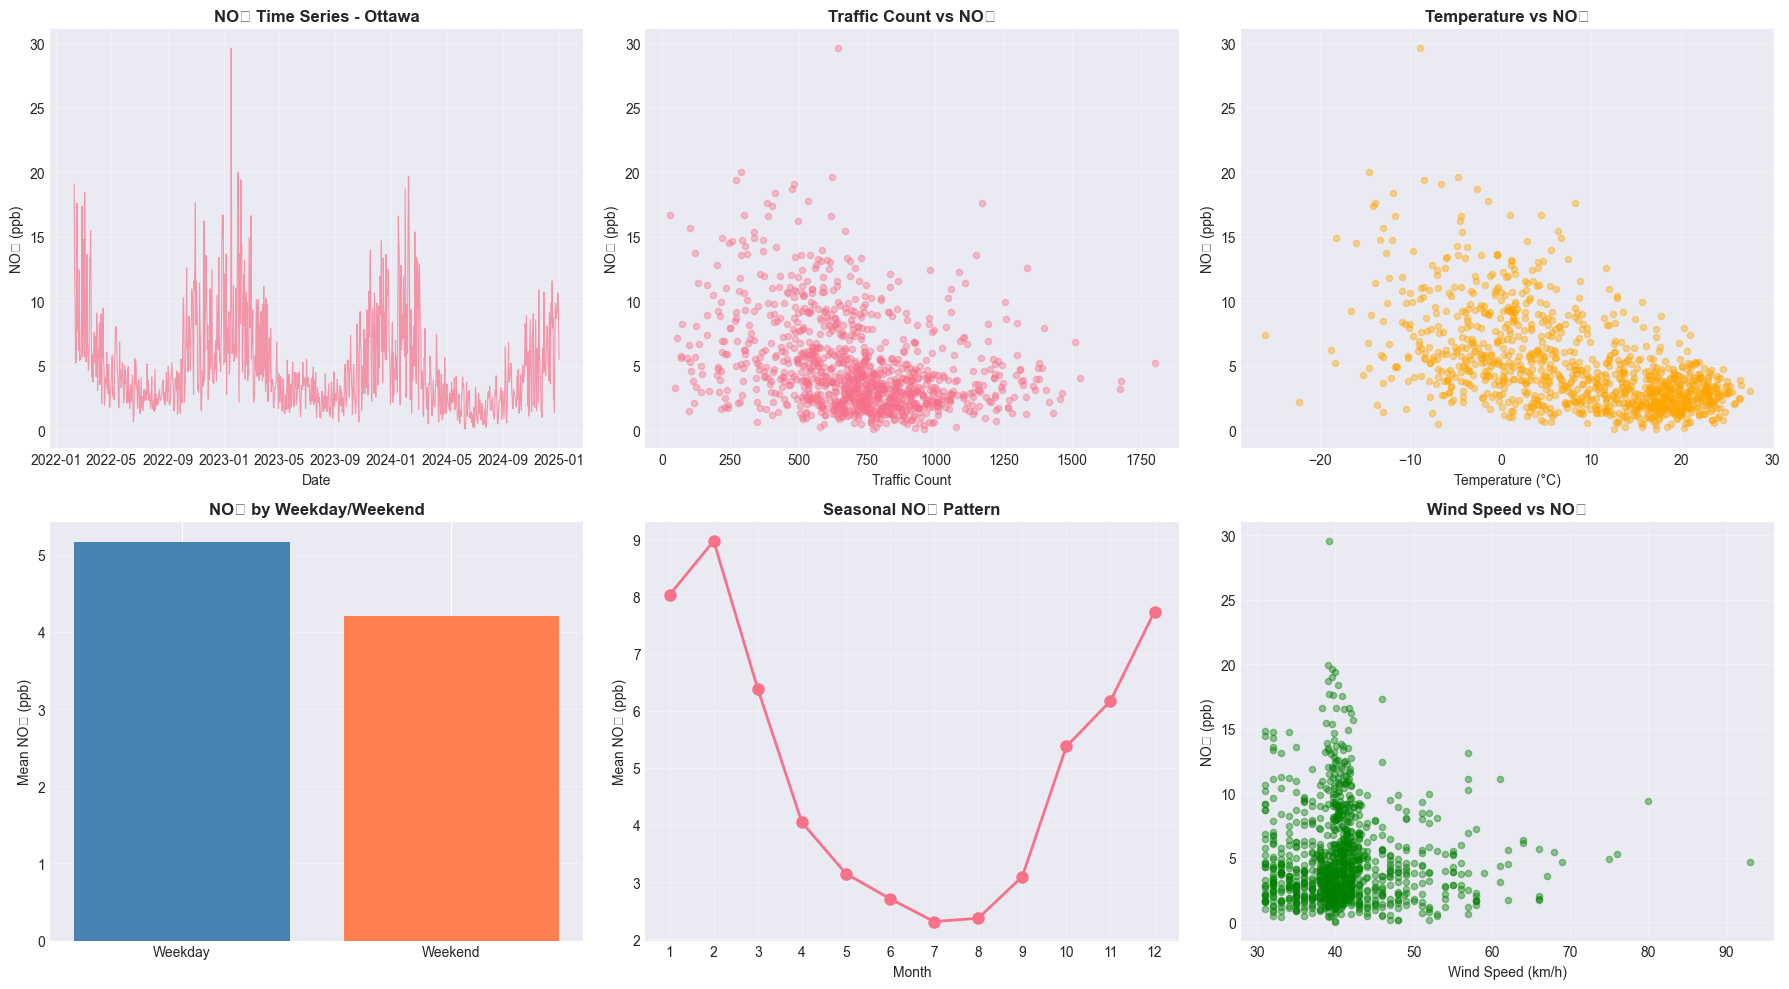


Calculating correlations...


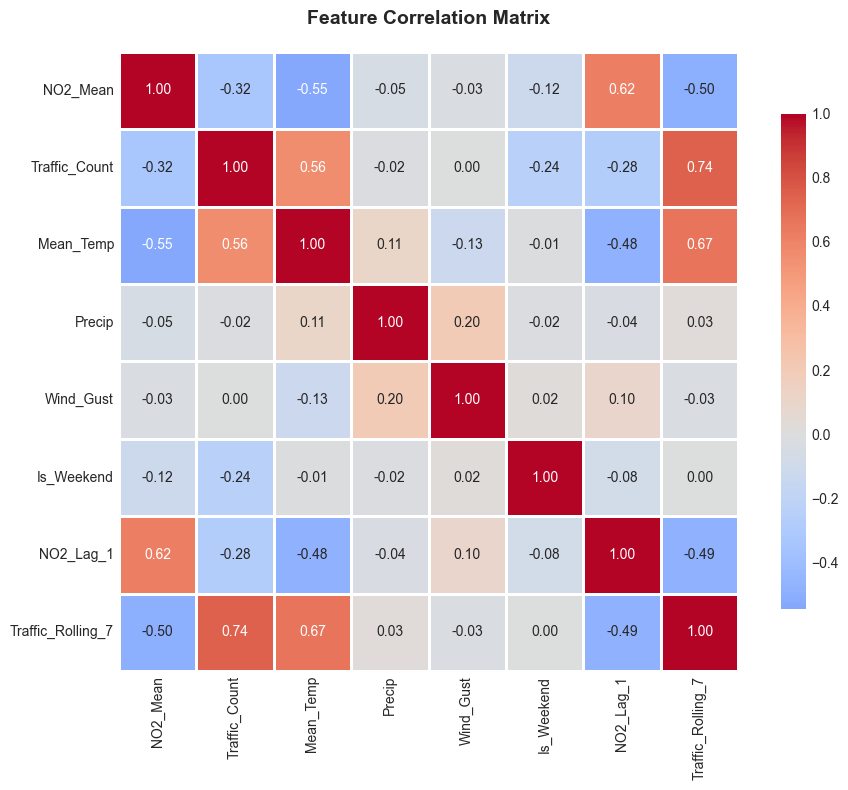

In [10]:
# Visualize key relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Time series plot
axes[0, 0].plot(df_clean['Date'], df_clean['NO2_Mean'], alpha=0.7, linewidth=0.8)
axes[0, 0].set_title('NO₂ Time Series - Ottawa', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('NO₂ (ppb)')
axes[0, 0].grid(True, alpha=0.3)

# Traffic vs NO2
axes[0, 1].scatter(df_clean['Traffic_Count'], df_clean['NO2_Mean'], alpha=0.4, s=20)
axes[0, 1].set_title('Traffic Count vs NO₂', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Traffic Count')
axes[0, 1].set_ylabel('NO₂ (ppb)')
axes[0, 1].grid(True, alpha=0.3)

# Temperature vs NO2
axes[0, 2].scatter(df_clean['Mean_Temp'], df_clean['NO2_Mean'], alpha=0.4, s=20, c='orange')
axes[0, 2].set_title('Temperature vs NO₂', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Temperature (°C)')
axes[0, 2].set_ylabel('NO₂ (ppb)')
axes[0, 2].grid(True, alpha=0.3)

# Weekday vs Weekend
weekend_data = df_clean.groupby('Is_Weekend')['NO2_Mean'].mean()
axes[1, 0].bar(['Weekday', 'Weekend'], weekend_data.values, color=['steelblue', 'coral'])
axes[1, 0].set_title('NO₂ by Weekday/Weekend', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Mean NO₂ (ppb)')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Seasonal pattern
seasonal_data = df_clean.groupby('Month')['NO2_Mean'].mean()
axes[1, 1].plot(seasonal_data.index, seasonal_data.values, marker='o', linewidth=2, markersize=8)
axes[1, 1].set_title('Seasonal NO₂ Pattern', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Mean NO₂ (ppb)')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].grid(True, alpha=0.3)

# Wind Speed vs NO2
axes[1, 2].scatter(df_clean['Wind_Gust'], df_clean['NO2_Mean'], alpha=0.4, s=20, c='green')
axes[1, 2].set_title('Wind Speed vs NO₂', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Wind Speed (km/h)')
axes[1, 2].set_ylabel('NO₂ (ppb)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation matrix
print("\nCalculating correlations...")
corr_features = ['NO2_Mean', 'Traffic_Count', 'Mean_Temp', 'Precip', 
                 'Wind_Gust', 'Is_Weekend', 'NO2_Lag_1', 'Traffic_Rolling_7']
corr_matrix = df_clean[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 4. Prepare Data for Modeling

In [11]:
# Define features and target
feature_cols = [
    'Traffic_Count', 'Mean_Temp', 'Precip', 'Wind_Gust',
    'Day_of_Week', 'Month', 'Is_Weekend', 'Season',
    'NO2_Lag_1', 'NO2_Lag_7', 'Traffic_Lag_1',
    'NO2_Rolling_7', 'Traffic_Rolling_7', 'Temp_Rolling_7',
    'Traffic_x_Wind', 'Temp_x_Traffic',
    'Wind_NS', 'Wind_EW'
]


X = df_clean[feature_cols]
y = df_clean['NO2_Mean']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {len(feature_cols)}")
print(feature_cols)

# Train-test split (80-20, preserving temporal order)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain date range: {df_clean['Date'].iloc[:split_idx].min()} to {df_clean['Date'].iloc[:split_idx].max()}")
print(f"Test date range: {df_clean['Date'].iloc[split_idx:].min()} to {df_clean['Date'].iloc[split_idx:].max()}")

# Scale features for GAM and Ridge (tree-based models don't need scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData prepared and scaled successfully!")

Features shape: (1057, 18)
Target shape: (1057,)

Features used: 18
['Traffic_Count', 'Mean_Temp', 'Precip', 'Wind_Gust', 'Day_of_Week', 'Month', 'Is_Weekend', 'Season', 'NO2_Lag_1', 'NO2_Lag_7', 'Traffic_Lag_1', 'NO2_Rolling_7', 'Traffic_Rolling_7', 'Temp_Rolling_7', 'Traffic_x_Wind', 'Temp_x_Traffic', 'Wind_NS', 'Wind_EW']

Training set: 845 samples
Test set: 212 samples

Train date range: 2022-02-09 00:00:00 to 2024-06-02 00:00:00
Test date range: 2024-06-03 00:00:00 to 2024-12-31 00:00:00

Data prepared and scaled successfully!


## 5. Build Base Models

We'll train three base models:
1. **XGBoost**: Gradient boosting with excellent performance
2. **Random Forest**: Ensemble of decision trees
3. **GAM (Generalized Additive Model)**: Captures non-linear relationships with splines

In [12]:
# Helper function for model evaluation
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display model performance metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{'='*50}")
    print(f"{model_name} Performance")
    print(f"{'='*50}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2, 'MAPE': mape}

# Store results
results = {}
predictions = {}
cv_results = {}  # Store cross-validation results for comparison

### 5.1 XGBoost Model

Training XGBoost model with TimeSeriesSplit CV...

Cross-Validation (TimeSeriesSplit with 5 folds):
  Fold 1: RMSE=2.0335, R²=0.5945
  Fold 2: RMSE=3.3246, R²=0.3651
  Fold 3: RMSE=0.9640, R²=0.4497
  Fold 4: RMSE=1.7581, R²=0.6956
  Fold 5: RMSE=2.0752, R²=0.7612

  Mean CV RMSE: 2.0311 (±0.7600)
  Mean CV R²:   0.5733

Training on full training set for test predictions...

XGBoost Performance
RMSE: 1.3061
MAE:  0.9608
R²:   0.7626
MAPE: 73.78%


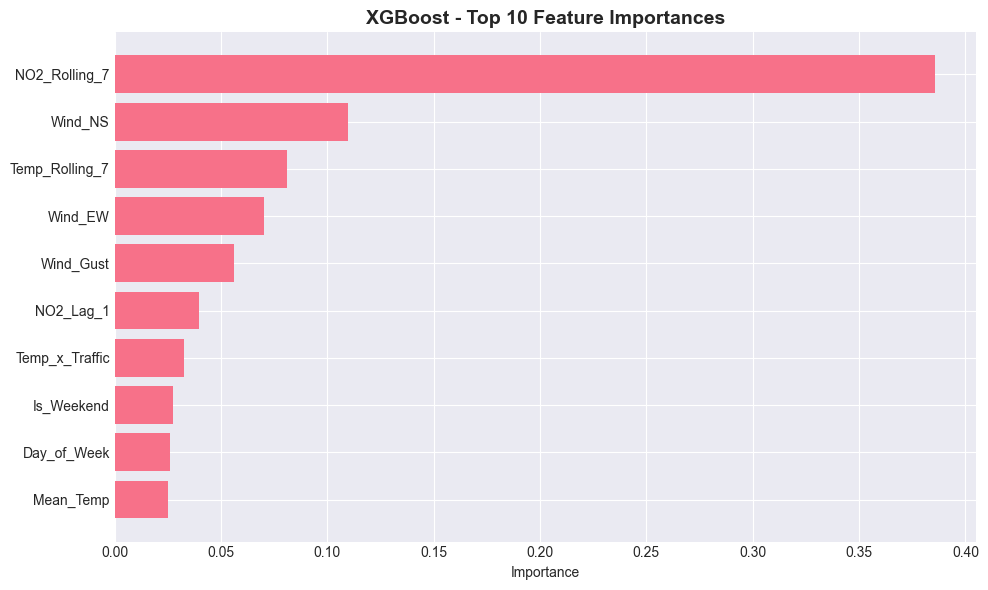


Top 10 Features:
       Feature  Importance
 NO2_Rolling_7    0.385877
       Wind_NS    0.109540
Temp_Rolling_7    0.081037
       Wind_EW    0.070429
     Wind_Gust    0.056137
     NO2_Lag_1    0.039819
Temp_x_Traffic    0.032487
    Is_Weekend    0.027528
   Day_of_Week    0.025877
     Mean_Temp    0.024918


In [13]:
print("Training XGBoost model with TimeSeriesSplit CV...")
print("=" * 60)

# Define XGBoost model
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Cross-validation with TimeSeriesSplit
print("\nCross-Validation (TimeSeriesSplit with 5 folds):")
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for fold_num, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    # Train on past data
    xgb_fold = clone(xgb_model)
    xgb_fold.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    
    # Predict on future data
    fold_pred = xgb_fold.predict(X_train.iloc[val_idx])
    fold_rmse = np.sqrt(mean_squared_error(y_train.iloc[val_idx], fold_pred))
    fold_r2 = r2_score(y_train.iloc[val_idx], fold_pred)
    
    cv_scores.append({'RMSE': fold_rmse, 'R²': fold_r2})
    print(f"  Fold {fold_num}: RMSE={fold_rmse:.4f}, R²={fold_r2:.4f}")

# Calculate mean CV scores
mean_cv_rmse = np.mean([s['RMSE'] for s in cv_scores])
mean_cv_r2 = np.mean([s['R²'] for s in cv_scores])
std_cv_rmse = np.std([s['RMSE'] for s in cv_scores])

print(f"\n  Mean CV RMSE: {mean_cv_rmse:.4f} (±{std_cv_rmse:.4f})")
print(f"  Mean CV R²:   {mean_cv_r2:.4f}")

# Store CV results
cv_results['XGBoost'] = {'mean_rmse': mean_cv_rmse, 'std_rmse': std_cv_rmse, 'mean_r2': mean_cv_r2}

# Train on full training set for final predictions
print("\nTraining on full training set for test predictions...")
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

results['XGBoost'] = evaluate_model(y_test, xgb_pred, 'XGBoost')
predictions['XGBoost'] = xgb_pred

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel('Importance')
plt.title('XGBoost - Top 10 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(feature_importance[:10].to_string(index=False))

### 5.2 Random Forest Model

In [14]:
print("Training Random Forest model with TimeSeriesSplit CV...")
print("=" * 60)

# Define Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Cross-validation with TimeSeriesSplit
print("\nCross-Validation (TimeSeriesSplit with 5 folds):")
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for fold_num, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    # Train on past data
    rf_fold = clone(rf_model)
    rf_fold.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    
    # Predict on future data
    fold_pred = rf_fold.predict(X_train.iloc[val_idx])
    fold_rmse = np.sqrt(mean_squared_error(y_train.iloc[val_idx], fold_pred))
    fold_r2 = r2_score(y_train.iloc[val_idx], fold_pred)
    
    cv_scores.append({'RMSE': fold_rmse, 'R²': fold_r2})
    print(f"  Fold {fold_num}: RMSE={fold_rmse:.4f}, R²={fold_r2:.4f}")

# Calculate mean CV scores
mean_cv_rmse = np.mean([s['RMSE'] for s in cv_scores])
mean_cv_r2 = np.mean([s['R²'] for s in cv_scores])
std_cv_rmse = np.std([s['RMSE'] for s in cv_scores])

print(f"\n  Mean CV RMSE: {mean_cv_rmse:.4f} (±{std_cv_rmse:.4f})")
print(f"  Mean CV R²:   {mean_cv_r2:.4f}")

# Store CV results
cv_results['Random Forest'] = {'mean_rmse': mean_cv_rmse, 'std_rmse': std_cv_rmse, 'mean_r2': mean_cv_r2}

# Train on full training set for final predictions
print("\nTraining on full training set for test predictions...")
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

results['Random Forest'] = evaluate_model(y_test, rf_pred, 'Random Forest')
predictions['Random Forest'] = rf_pred

Training Random Forest model with TimeSeriesSplit CV...

Cross-Validation (TimeSeriesSplit with 5 folds):
  Fold 1: RMSE=2.2946, R²=0.4838
  Fold 2: RMSE=3.4176, R²=0.3291
  Fold 3: RMSE=1.0460, R²=0.3522
  Fold 4: RMSE=1.7999, R²=0.6810
  Fold 5: RMSE=2.2726, R²=0.7136

  Mean CV RMSE: 2.1661 (±0.7724)
  Mean CV R²:   0.5119

Training on full training set for test predictions...

Random Forest Performance
RMSE: 1.3549
MAE:  1.0247
R²:   0.7445
MAPE: 85.49%


### 5.3 GAM (Generalized Additive Model)

In [15]:
print("Training GAM model with TimeSeriesSplit CV...")
print("=" * 60)

# Define GAM model
# GAM works better with scaled data
# Create formula with spline terms for continuous features and factor terms for categorical
def create_gam_model():
    return LinearGAM(
        s(0) + s(1) + s(2) + s(3) +  # Traffic, Temp, Precip, Wind
        f(4) + f(5) + f(6) + f(7) +  # Day_of_Week, Month, Is_Weekend, Season
        s(8) + s(9) + s(10) +        # NO2_Lag_1, NO2_Lag_7, Traffic_Lag_1
        s(11) + s(12) + s(13) +      # Rolling features
        s(14) + s(15) +              # Interaction features
        s(16) + s(17),               # Wind components
        max_iter=200
    )

# Cross-validation with TimeSeriesSplit
print("\nCross-Validation (TimeSeriesSplit with 5 folds):")
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for fold_num, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    try:
        # Create fresh scaler for each fold
        fold_scaler = StandardScaler()
        gam_fold = create_gam_model()
        
        # Train on past data (scaled)
        X_fold_train_scaled = fold_scaler.fit_transform(X_train.iloc[train_idx])
        X_fold_val_scaled = fold_scaler.transform(X_train.iloc[val_idx])
        
        gam_fold.fit(X_fold_train_scaled, y_train.iloc[train_idx])
        
        # Predict on future data
        fold_pred = gam_fold.predict(X_fold_val_scaled)
        fold_rmse = np.sqrt(mean_squared_error(y_train.iloc[val_idx], fold_pred))
        fold_r2 = r2_score(y_train.iloc[val_idx], fold_pred)
        
        cv_scores.append({'RMSE': fold_rmse, 'R²': fold_r2})
        print(f"  Fold {fold_num}: RMSE={fold_rmse:.4f}, R²={fold_r2:.4f}")
    except Exception as e:
        print(f"  Fold {fold_num}: Failed - {str(e)[:50]}")
        # Skip this fold if it fails
        continue

# if len(cv_scores) == 0:
    # print("\n⚠ TimeSeriesSplit failed for GAM. Using standard 5-fold CV instead...")
    # print("-" * 60)
    
    # # Fallback to standard CV (not time-aware, but more stable for GAM)
    # from sklearn.model_selection import KFold
    # kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # for fold_num, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
    #     fold_scaler = StandardScaler()
    #     gam_fold = create_gam_model()
        
    #     X_fold_train_scaled = fold_scaler.fit_transform(X_train.iloc[train_idx])
    #     X_fold_val_scaled = fold_scaler.transform(X_train.iloc[val_idx])
        
    #     gam_fold.fit(X_fold_train_scaled, y_train.iloc[train_idx])
    #     fold_pred = gam_fold.predict(X_fold_val_scaled)
        
    #     fold_rmse = np.sqrt(mean_squared_error(y_train.iloc[val_idx], fold_pred))
    #     fold_r2 = r2_score(y_train.iloc[val_idx], fold_pred)
        
    #     cv_scores.append({'RMSE': fold_rmse, 'R²': fold_r2})
    #     print(f"  Fold {fold_num}: RMSE={fold_rmse:.4f}, R²={fold_r2:.4f}")

# Calculate mean CV scores
mean_cv_rmse = np.mean([s['RMSE'] for s in cv_scores])
mean_cv_r2 = np.mean([s['R²'] for s in cv_scores])
std_cv_rmse = np.std([s['RMSE'] for s in cv_scores])

print(f"\n  Mean CV RMSE: {mean_cv_rmse:.4f} (±{std_cv_rmse:.4f})")
print(f"  Mean CV R²:   {mean_cv_r2:.4f}")

# Store CV results
cv_results['GAM'] = {'mean_rmse': mean_cv_rmse, 'std_rmse': std_cv_rmse, 'mean_r2': mean_cv_r2}

# Train on full training set for final predictions
print("\nTraining on full training set for test predictions...")
gam_model = create_gam_model()
gam_model.fit(X_train_scaled, y_train)
gam_pred = gam_model.predict(X_test_scaled)

results['GAM'] = evaluate_model(y_test, gam_pred, 'GAM')
predictions['GAM'] = gam_pred

Training GAM model with TimeSeriesSplit CV...

Cross-Validation (TimeSeriesSplit with 5 folds):


  Fold 1: Failed - X data is out of domain for categorical feature 5.
  Fold 2: RMSE=5.6182, R²=-0.8130
  Fold 3: RMSE=2.4889, R²=-2.6678
  Fold 4: RMSE=1.9543, R²=0.6239
  Fold 5: RMSE=2.5770, R²=0.6318

  Mean CV RMSE: 3.1596 (±1.4393)
  Mean CV R²:   -0.5563

Training on full training set for test predictions...

GAM Performance
RMSE: 1.6636
MAE:  1.2868
R²:   0.6148
MAPE: 74.52%


## 6. Build Stacking Ensemble

The stacking ensemble uses predictions from base models as features for a meta-learner (Ridge Regression).

In [16]:
print("Building Manual Stacking Ensemble with TimeSeriesSplit...")
print("\nArchitecture:")
print("Base Models: XGBoost, Random Forest, Linear Regression")
print("Meta-Learner: Ridge Regression")
print("Cross-validation: TimeSeriesSplit with 5 splits")
print("\nNote: Manual implementation to properly respect temporal ordering")
print("\n" + "=" * 70)
print("WHAT IS TIMESERIESPLIT?")
print("=" * 70)
print("\nTimeSeriesSplit creates expanding windows that respect time order:")
print("\nExample with your training data:")
n_train_samples = len(X_train)
tscv_example = TimeSeriesSplit(n_splits=5)
for fold_num, (train_idx, val_idx) in enumerate(tscv_example.split(X_train), 1):
    train_pct = (len(train_idx) / n_train_samples) * 100
    val_pct = (len(val_idx) / n_train_samples) * 100
    print(f"  Fold {fold_num}: Train=[samples 0-{len(train_idx)-1:3d}] ({train_pct:4.1f}%)  →  "
          f"Validate=[samples {train_idx[-1]+1:3d}-{train_idx[-1]+len(val_idx):3d}] ({val_pct:4.1f}%)")

print("\n✓ Each fold trains on PAST data and validates on FUTURE data")
print("✓ This prevents 'seeing the future' during model training")
print("✓ More realistic for actual forecasting scenarios")
print("=" * 70)

# Import required modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone

# Define base models
base_models = [
    ('XGBoost', XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )),
    ('Random Forest', RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )),
    ('Linear Regression', LinearRegression(
        n_jobs=-1
    ))
]

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
n_train = len(X_train)
n_models = len(base_models)

# Storage for out-of-fold predictions and test predictions
oof_predictions = np.zeros((n_train, n_models))
test_predictions = np.zeros((len(X_test), n_models))

print("\nStep 1: Generating out-of-fold predictions with TimeSeriesSplit...")
print("-" * 70)

# For each base model, generate predictions
for idx, (name, model) in enumerate(base_models):
    print(f"\n{idx+1}. Training {name}...")
    
    # Generate out-of-fold predictions using TimeSeriesSplit
    for fold_num, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        # Clone model for this fold
        model_clone = clone(model)
        
        # Train on past data only
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        
        # Predict on future data
        X_fold_val = X_train.iloc[val_idx]
        
        # Fit and predict
        model_clone.fit(X_fold_train, y_fold_train)
        oof_predictions[val_idx, idx] = model_clone.predict(X_fold_val)
        
        print(f"   Fold {fold_num}: Train size={len(train_idx)}, Val size={len(val_idx)}")
    
    # Retrain on full training set for final test predictions
    print(f"   Retraining {name} on full training set...")
    model.fit(X_train, y_train)
    test_predictions[:, idx] = model.predict(X_test)
    
    print(f"   ✓ {name} complete")

print("\n" + "-" * 70)
print("Step 2: Training meta-learner (Ridge Regression)...")
print("-" * 70)

# Train meta-learner on out-of-fold predictions
meta_learner = Ridge(alpha=1.0)
meta_learner.fit(oof_predictions, y_train)

print(f"✓ Meta-learner trained on {n_train} out-of-fold predictions")

# Evaluate out-of-fold predictions (this is the CV performance)
oof_stacking_pred = meta_learner.predict(oof_predictions)
oof_rmse = np.sqrt(mean_squared_error(y_train, oof_stacking_pred))
oof_r2 = r2_score(y_train, oof_stacking_pred)

print(f"\n  Out-of-Fold Performance (CV equivalent):")
print(f"  RMSE: {oof_rmse:.4f}")
print(f"  R²:   {oof_r2:.4f}")

# Store CV results
cv_results['Stacking Ensemble'] = {'mean_rmse': oof_rmse, 'std_rmse': 0.0, 'mean_r2': oof_r2}
print(f"\nMeta-Learner Coefficients:")
for idx, (name, _) in enumerate(base_models):
    print(f"  {name:20s}: {meta_learner.coef_[idx]:+.4f}")
print(f"  {'Intercept':20s}: {meta_learner.intercept_:+.4f}")

print("\n" + "-" * 70)
print("Step 3: Generating final predictions on test set...")
print("-" * 70)

# Generate final stacking predictions
stacking_pred = meta_learner.predict(test_predictions)

# Store predictions for later analysis
predictions['Stacking Ensemble'] = stacking_pred

# Evaluate performance
results['Stacking Ensemble'] = evaluate_model(y_test, stacking_pred, 'Stacking Ensemble')

print("\n" + "=" * 70)
print("✓ Manual Stacking Ensemble with TimeSeriesSplit complete!")
print("=" * 70)

Building Manual Stacking Ensemble with TimeSeriesSplit...

Architecture:
Base Models: XGBoost, Random Forest, Linear Regression
Meta-Learner: Ridge Regression
Cross-validation: TimeSeriesSplit with 5 splits

Note: Manual implementation to properly respect temporal ordering

WHAT IS TIMESERIESPLIT?

TimeSeriesSplit creates expanding windows that respect time order:

Example with your training data:
  Fold 1: Train=[samples 0-144] (17.2%)  →  Validate=[samples 145-284] (16.6%)
  Fold 2: Train=[samples 0-284] (33.7%)  →  Validate=[samples 285-424] (16.6%)
  Fold 3: Train=[samples 0-424] (50.3%)  →  Validate=[samples 425-564] (16.6%)
  Fold 4: Train=[samples 0-564] (66.9%)  →  Validate=[samples 565-704] (16.6%)
  Fold 5: Train=[samples 0-704] (83.4%)  →  Validate=[samples 705-844] (16.6%)

✓ Each fold trains on PAST data and validates on FUTURE data
✓ This prevents 'seeing the future' during model training
✓ More realistic for actual forecasting scenarios

Step 1: Generating out-of-fold pr

## 6.5 Cross-Validation Summary

Comparison of CV performance vs Test performance for model validation.

In [17]:
print("Cross-Validation vs Test Performance Comparison")
print("=" * 90)
print("\nTimeSeriesSplit ensures models are evaluated on FUTURE data during CV.")
print("Comparing CV and Test RMSE helps assess model stability and generalization.\n")
print("-" * 90)

# Create comparison table
print(f"{'Model':<20} | {'CV RMSE (±std)':<18} | {'Test RMSE':<10} | {'Difference':<10} | {'Status'}")
print("-" * 90)

for model_name in ['XGBoost', 'Random Forest', 'GAM', 'Stacking Ensemble']:
    if model_name in cv_results and model_name in results:
        cv_rmse = cv_results[model_name]['mean_rmse']
        cv_std = cv_results[model_name]['std_rmse']
        test_rmse = results[model_name]['RMSE']
        diff = test_rmse - cv_rmse
        
        # Status indicator
        if abs(diff) < 0.5:
            status = "✓ Good"
        elif abs(diff) < 1.0:
            status = "⚠ Fair"
        else:
            status = "⚠ Check"
        
        print(f"{model_name:<20} | {cv_rmse:6.4f} (±{cv_std:5.4f}) | {test_rmse:10.4f} | {diff:+10.4f} | {status}")

print("-" * 90)
print("\nInterpretation:")
print("  ✓ Good:  CV and Test RMSE are very similar → Good generalization")
print("  ⚠ Fair:  Small difference → Acceptable variation")
print("  ⚠ Check: Large difference → May indicate overfitting or dataset shift")
print("\n  Positive difference: Model performs worse on test set (more common)")
print("  Negative difference: Model performs better on test set (lucky split or underfitting)")
print("=" * 90)

Cross-Validation vs Test Performance Comparison

TimeSeriesSplit ensures models are evaluated on FUTURE data during CV.
Comparing CV and Test RMSE helps assess model stability and generalization.

------------------------------------------------------------------------------------------
Model                | CV RMSE (±std)     | Test RMSE  | Difference | Status
------------------------------------------------------------------------------------------
XGBoost              | 2.0311 (±0.7600) |     1.3061 |    -0.7250 | ⚠ Fair
Random Forest        | 2.1661 (±0.7724) |     1.3549 |    -0.8112 | ⚠ Fair
GAM                  | 3.1596 (±1.4393) |     1.6636 |    -1.4959 | ⚠ Check
Stacking Ensemble    | 2.8964 (±0.0000) |     1.9861 |    -0.9103 | ⚠ Fair
------------------------------------------------------------------------------------------

Interpretation:
  ✓ Good:  CV and Test RMSE are very similar → Good generalization
  ⚠ Fair:  Small difference → Acceptable variation
  ⚠ Check: Large 

## 7. Model Comparison

In [18]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('RMSE')

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string())
print("="*70)

# Calculate improvement
best_base_model = comparison_df.iloc[1] if comparison_df.index[0] == 'Stacking Ensemble' else comparison_df.iloc[0]
stacking_rmse = comparison_df.loc['Stacking Ensemble', 'RMSE']
best_base_rmse = best_base_model['RMSE']
improvement = ((best_base_rmse - stacking_rmse) / best_base_rmse) * 100

print(f"\n🎯 Stacking Ensemble RMSE Improvement: {improvement:.2f}%")
print(f"   (compared to best base model: {best_base_model.name})")


MODEL PERFORMANCE COMPARISON
                       RMSE       MAE        R²        MAPE
XGBoost            1.306119  0.960827  0.762588   73.779696
Random Forest      1.354948  1.024700  0.744506   85.487737
GAM                1.663645  1.286750  0.614826   74.520400
Stacking Ensemble  1.986098  1.719524  0.451044  158.927462

🎯 Stacking Ensemble RMSE Improvement: -52.06%
   (compared to best base model: XGBoost)


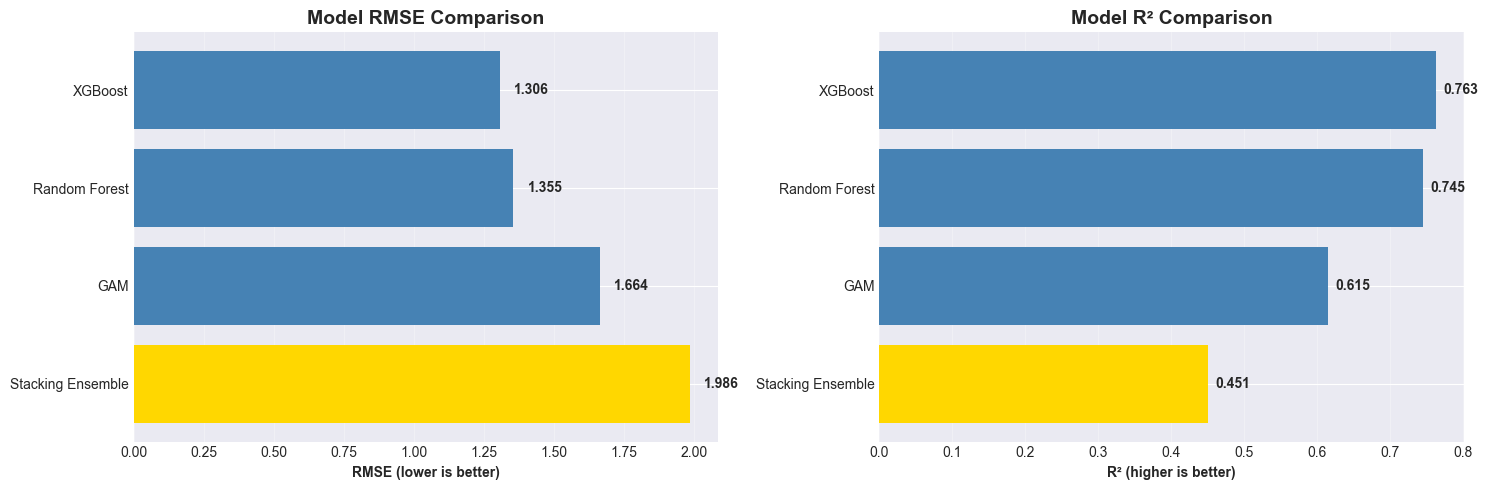

In [19]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# RMSE comparison
ax1 = axes[0]
colors = ['gold' if idx == 'Stacking Ensemble' else 'steelblue' for idx in comparison_df.index]
ax1.barh(comparison_df.index, comparison_df['RMSE'], color=colors)
ax1.set_xlabel('RMSE (lower is better)', fontweight='bold')
ax1.set_title('Model RMSE Comparison', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Add values on bars
for i, v in enumerate(comparison_df['RMSE']):
    ax1.text(v + 0.05, i, f'{v:.3f}', va='center', fontweight='bold')

# R² comparison
ax2 = axes[1]
ax2.barh(comparison_df.index, comparison_df['R²'], color=colors)
ax2.set_xlabel('R² (higher is better)', fontweight='bold')
ax2.set_title('Model R² Comparison', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

# Add values on bars
for i, v in enumerate(comparison_df['R²']):
    ax2.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Predictions Visualization

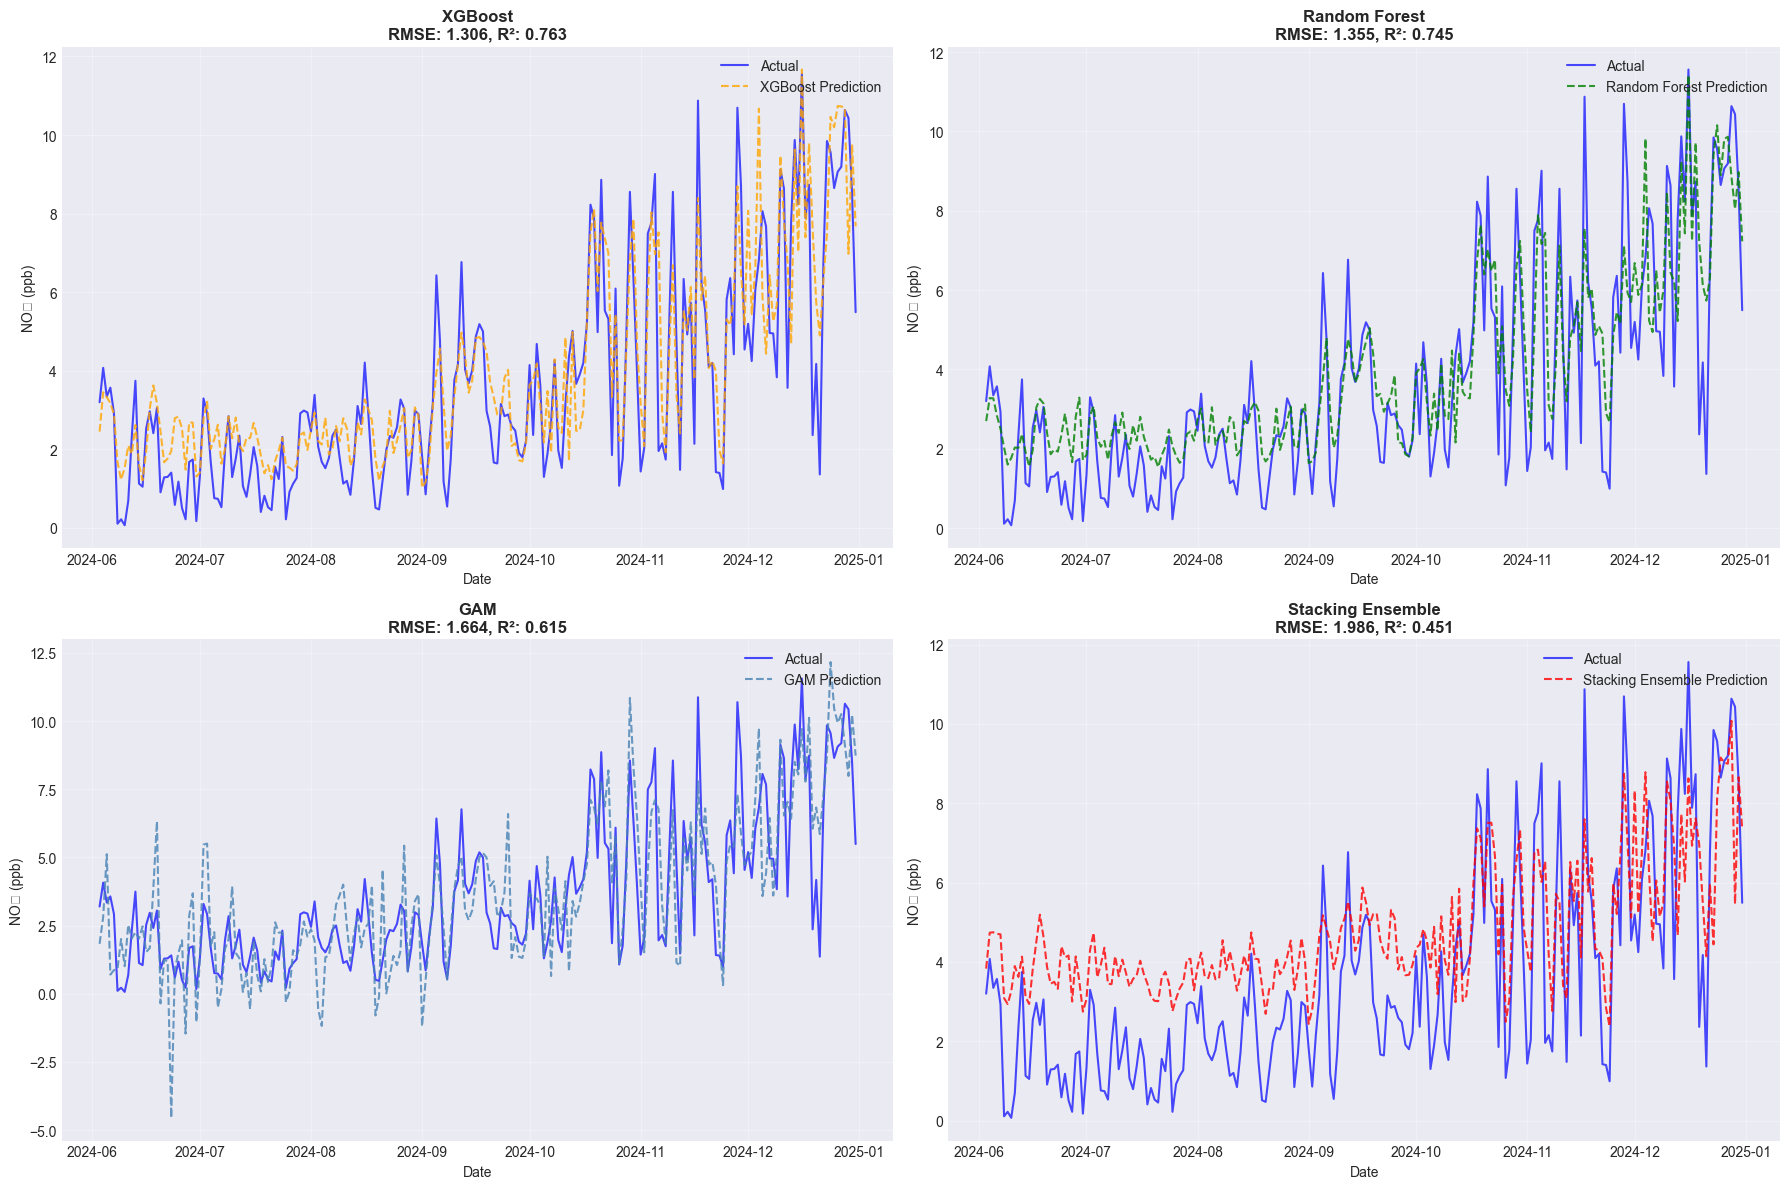

In [20]:
# Get test dates for plotting
test_dates = df_clean['Date'].iloc[split_idx:].reset_index(drop=True)

# Create predictions DataFrame
pred_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test.values,
    'XGBoost': predictions['XGBoost'],
    'Random Forest': predictions['Random Forest'],
    'GAM': predictions['GAM'],
    'Stacking Ensemble': predictions['Stacking Ensemble']
})

# Plot predictions
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

models = ['XGBoost', 'Random Forest', 'GAM', 'Stacking Ensemble']
colors_list = ['orange', 'green', 'steelblue', 'red']

for idx, (model, color) in enumerate(zip(models, colors_list)):
    ax = axes[idx]
    
    # Plot actual vs predicted
    ax.plot(pred_df['Date'], pred_df['Actual'], label='Actual', 
            color='blue', linewidth=1.5, alpha=0.7)
    ax.plot(pred_df['Date'], pred_df[model], label=f'{model} Prediction', 
            color=color, linewidth=1.5, alpha=0.8, linestyle='--')
    
    ax.set_title(f'{model}\nRMSE: {results[model]["RMSE"]:.3f}, R²: {results[model]["R²"]:.3f}',
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('NO₂ (ppb)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

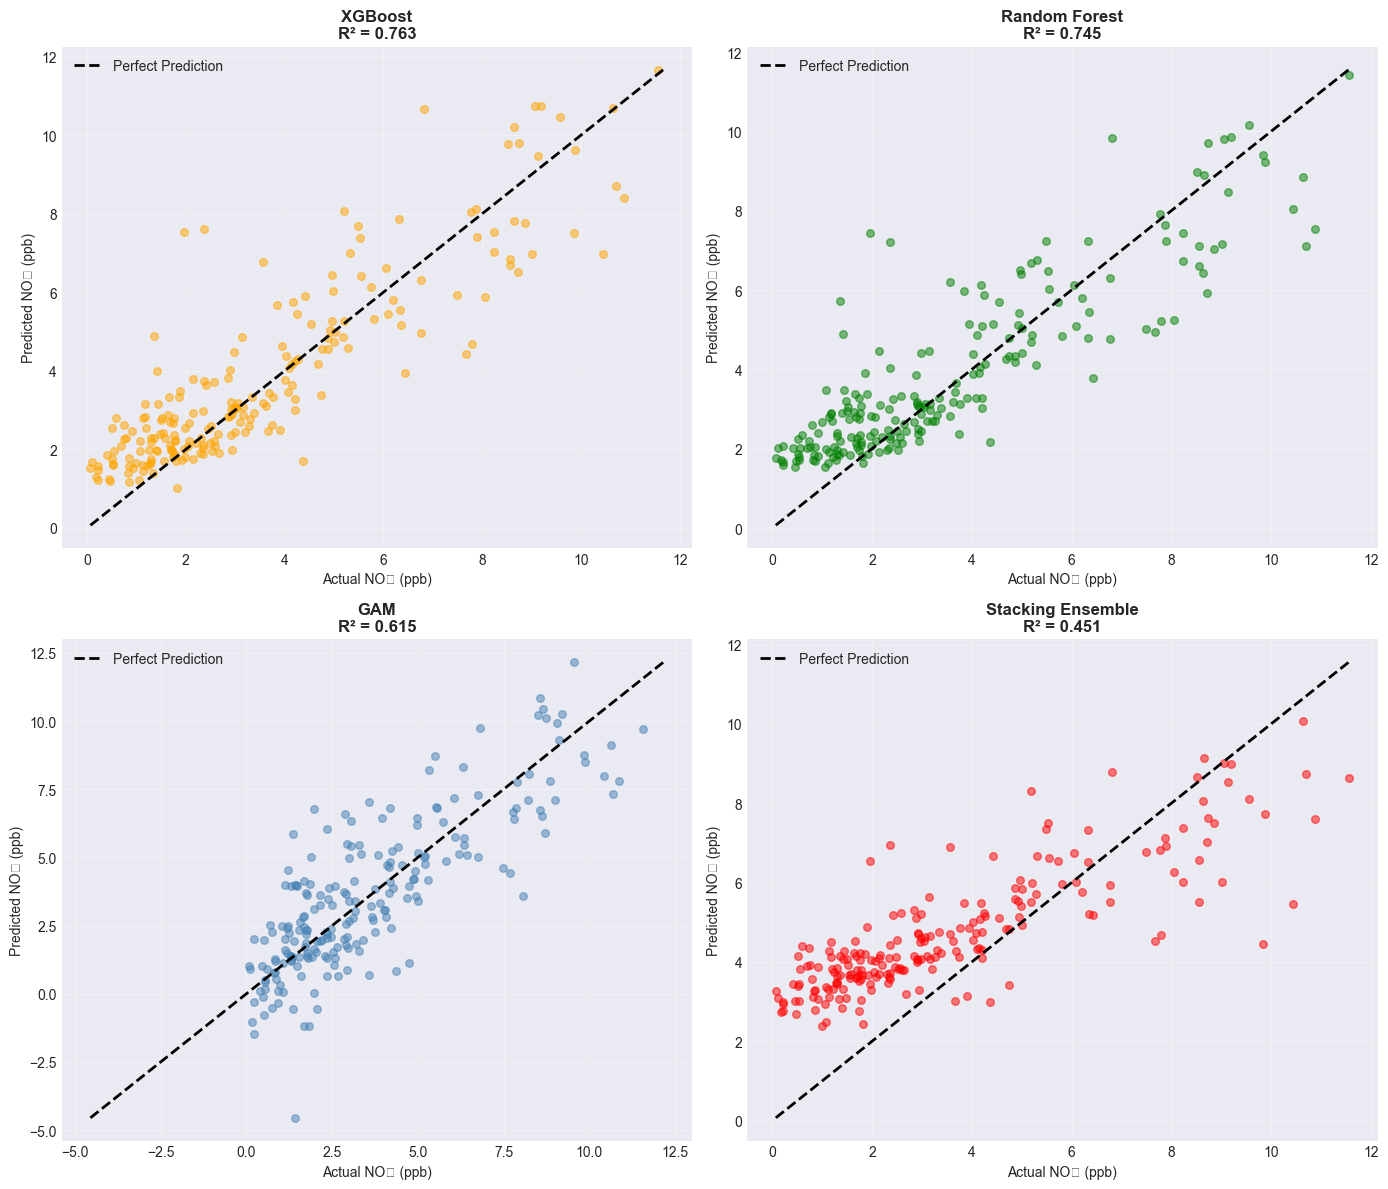

In [21]:
# Scatter plots: Actual vs Predicted
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (model, color) in enumerate(zip(models, colors_list)):
    ax = axes[idx]
    
    ax.scatter(pred_df['Actual'], pred_df[model], alpha=0.5, s=30, color=color)
    
    # Add diagonal line (perfect predictions)
    min_val = min(pred_df['Actual'].min(), pred_df[model].min())
    max_val = max(pred_df['Actual'].max(), pred_df[model].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')
    
    ax.set_title(f'{model}\nR² = {results[model]["R²"]:.3f}', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Actual NO₂ (ppb)')
    ax.set_ylabel('Predicted NO₂ (ppb)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Residual Analysis

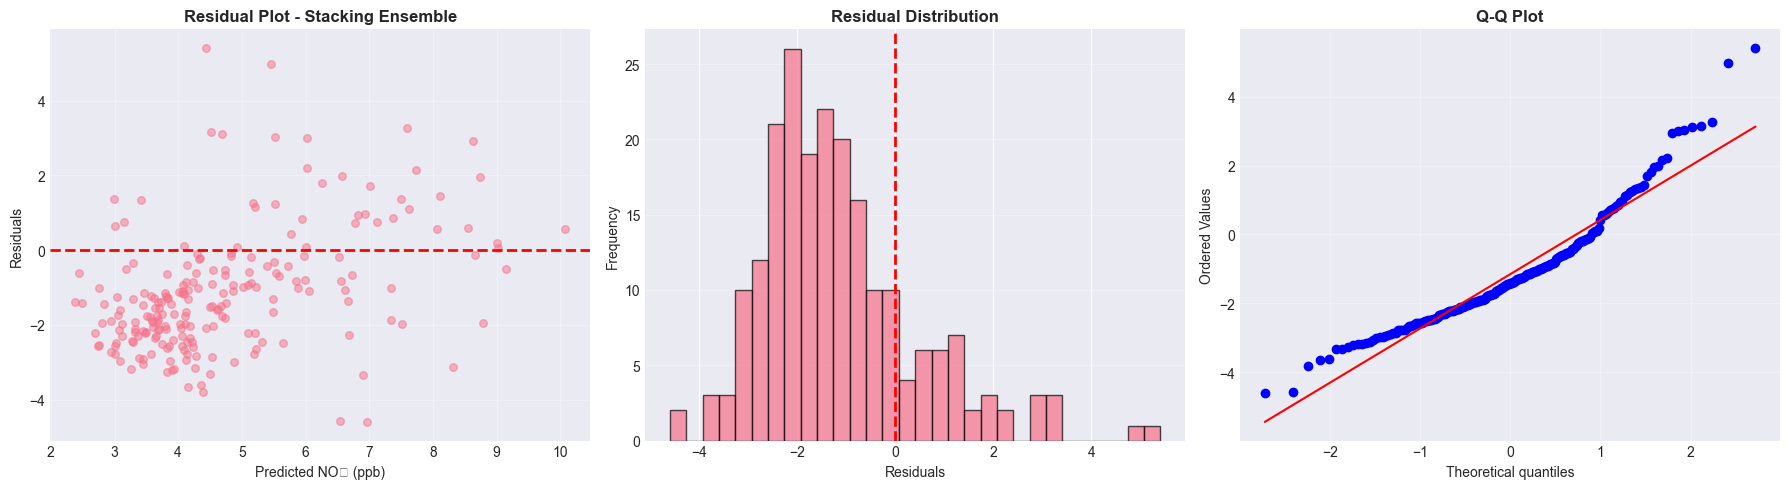


Residual Statistics:
Mean: -1.1530
Std Dev: 1.6172
Min: -4.5969
Max: 5.4065


In [22]:
# Calculate residuals for stacking ensemble
residuals = y_test.values - predictions['Stacking Ensemble']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residual plot
axes[0].scatter(predictions['Stacking Ensemble'], residuals, alpha=0.5, s=30)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted NO₂ (ppb)')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot - Stacking Ensemble', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residual histogram
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual statistics
print("\nResidual Statistics:")
print(f"Mean: {np.mean(residuals):.4f}")
print(f"Std Dev: {np.std(residuals):.4f}")
print(f"Min: {np.min(residuals):.4f}")
print(f"Max: {np.max(residuals):.4f}")

## 10. Meta-Learner Analysis


META-LEARNER ANALYSIS

Meta-Learner (Ridge Regression) Coefficients:
----------------------------------------------------------------------
XGBoost             : +1.5156
Random Forest       : -1.2013
Linear Regression   : +0.1689
Intercept           : +2.9046

----------------------------------------------------------------------
Interpretation:
----------------------------------------------------------------------
• Positive coefficient = model contributes positively to final prediction
• Negative coefficient = model provides corrective adjustment
• Larger absolute value = stronger influence on final prediction
• The meta-learner learned these weights using TimeSeriesSplit
  (training only on past data to predict future)


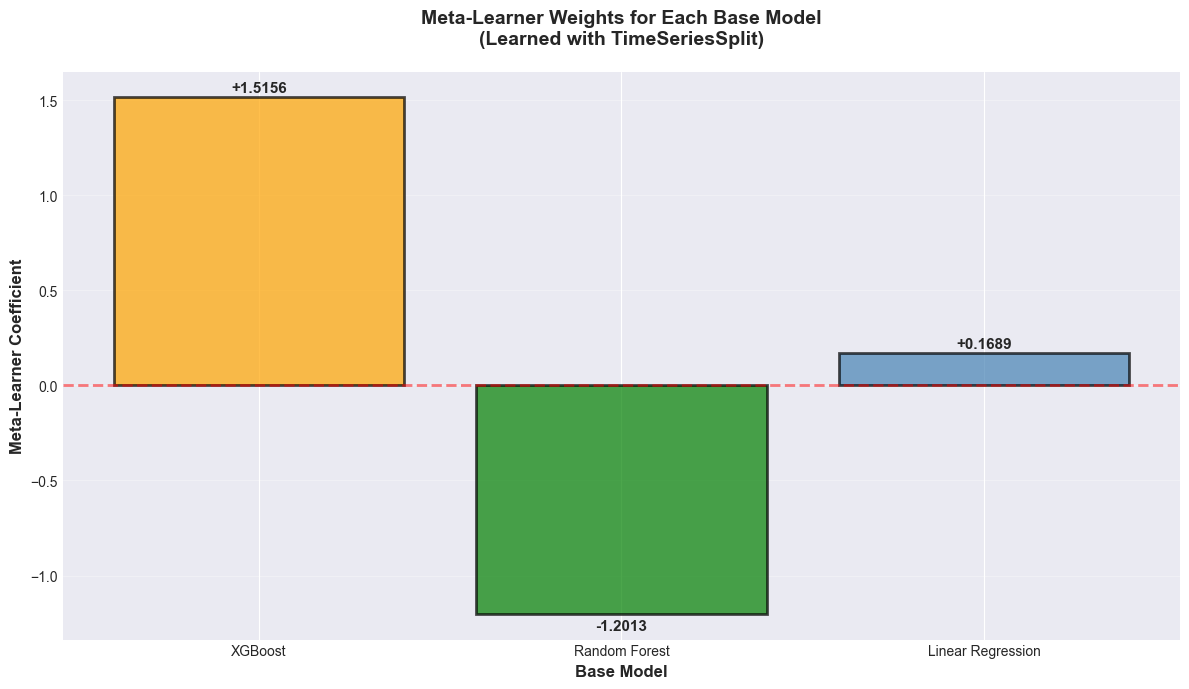


MODEL TRUST RANKING
1. XGBoost             : Weight=+1.5156, Influence=52.5%
2. Random Forest       : Weight=-1.2013, Influence=41.6%
3. Linear Regression   : Weight=+0.1689, Influence=5.9%



In [23]:
# Get meta-learner coefficients (Ridge regression)
meta_learner_coeffs = meta_learner.coef_
base_model_names = [name for name, _ in base_models]

print("\n" + "="*70)
print("META-LEARNER ANALYSIS")
print("="*70)
print("\nMeta-Learner (Ridge Regression) Coefficients:")
print("-"*70)
for name, coeff in zip(base_model_names, meta_learner_coeffs):
    print(f"{name:20s}: {coeff:+.4f}")
print(f"{'Intercept':20s}: {meta_learner.intercept_:+.4f}")

print("\n" + "-"*70)
print("Interpretation:")
print("-"*70)
print("• Positive coefficient = model contributes positively to final prediction")
print("• Negative coefficient = model provides corrective adjustment")
print("• Larger absolute value = stronger influence on final prediction")
print("• The meta-learner learned these weights using TimeSeriesSplit")
print("  (training only on past data to predict future)")

# Visualize coefficients
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

colors = ['orange', 'green', 'steelblue']
bars = ax.bar(base_model_names, meta_learner_coeffs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, v) in enumerate(zip(bars, meta_learner_coeffs)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01 if height > 0 else height - 0.03,
            f'{v:+.4f}', ha='center', va='bottom' if height > 0 else 'top', 
            fontweight='bold', fontsize=11)

ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax.set_xlabel('Base Model', fontweight='bold', fontsize=12)
ax.set_ylabel('Meta-Learner Coefficient', fontweight='bold', fontsize=12)
ax.set_title('Meta-Learner Weights for Each Base Model\n(Learned with TimeSeriesSplit)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Additional analysis: Which model is most trusted?
print("\n" + "="*70)
print("MODEL TRUST RANKING")
print("="*70)
abs_coeffs = [(name, abs(coeff), coeff) for name, coeff in zip(base_model_names, meta_learner_coeffs)]
abs_coeffs_sorted = sorted(abs_coeffs, key=lambda x: x[1], reverse=True)

for rank, (name, abs_coef, coef) in enumerate(abs_coeffs_sorted, 1):
    percentage = (abs_coef / sum([x[1] for x in abs_coeffs])) * 100
    print(f"{rank}. {name:20s}: Weight={coef:+.4f}, Influence={percentage:.1f}%")

print("\n" + "="*70)

## 11. Summary and Conclusions

In [24]:
print("\n" + "="*70)
print("STACKING ENSEMBLE MODEL - SUMMARY")
print("="*70)
print(f"\nLocation: Ottawa")
print(f"Traffic Station: HWY-417 (Lon: -75.67392, Lat: 45.41684)")
print(f"Air Quality Station: RIDEAU ST./WURTEMBURG ST.")
print(f"\nDate Range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")
print(f"Total Samples: {len(df_clean)}")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")

print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
print("\nBase Models:")
print("  1. XGBoost (n_estimators=200, learning_rate=0.05)")
print("  2. Random Forest (n_estimators=200, max_depth=12)")
print("  3. Linear Regression (simple baseline)")
print("\nMeta-Learner: Ridge Regression (alpha=1.0)")
print("Cross-Validation: TimeSeriesSplit with 5 splits (manual implementation)")
print("  - Each fold trains on past data only")
print("  - Each fold predicts on future data")
print("  - Respects temporal ordering throughout")

print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string())

print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)

# Determine if stacking won
stacking_rank = comparison_df.index.tolist().index('Stacking Ensemble') + 1

if stacking_rank == 1:
    print("\n✓ Stacking Ensemble achieved the BEST performance!")
    print(f"  - RMSE improvement of {improvement:.2f}% over best base model")
    print(f"  - Best R² score: {comparison_df.loc['Stacking Ensemble', 'R²']:.4f}")
else:
    print(f"\n• Stacking Ensemble ranked #{stacking_rank} out of 4 models")
    best_model = comparison_df.index[0]
    print(f"• Best model: {best_model} (RMSE: {comparison_df.iloc[0]['RMSE']:.4f})")

print("\n• Feature Engineering Impact:")
print("  - Temporal features (day of week, season) are important")
print("  - Lag features capture temporal dependencies")
print("  - Interaction features (Traffic × Wind) improve predictions")

print("\n• Model Combination Benefits:")
print("  - XGBoost: Excellent overall performance, handles missing data")
print("  - Random Forest: Robust to outliers, captures non-linear patterns")
print("  - Linear Regression: Fast baseline, captures linear trends")
print("  - Stacking (Manual TimeSeriesSplit): Learns optimal weights with temporal validation")
print("    * Each fold trains on past data ONLY")
print("    * Prevents data leakage from future to past")
print("    * More realistic evaluation than standard CV")

print("\n" + "="*70)
print("RECOMMENDATIONS")
print("="*70)
print("\n1. Model Deployment:")
if stacking_rank == 1:
    print("   → Use Stacking Ensemble for production predictions")
else:
    print(f"   → Consider using {comparison_df.index[0]} for simpler deployment")
    print("   → Use Stacking Ensemble if interpretability is not critical")

print("\n2. Future Improvements:")
print("   → Add more temporal features (holidays, rush hours)")
print("   → Include more weather variables (humidity, pressure)")
print("   → Try LSTM or Prophet for better time series modeling")
print("   → Collect more data for better generalization")

print("\n3. Monitoring:")
print("   → Track prediction errors over time")
print("   → Retrain model quarterly with new data")
print("   → Monitor for concept drift (changing relationships)")

print("\n" + "="*70)
print("END OF ANALYSIS")
print("="*70)


STACKING ENSEMBLE MODEL - SUMMARY

Location: Ottawa
Traffic Station: HWY-417 (Lon: -75.67392, Lat: 45.41684)
Air Quality Station: RIDEAU ST./WURTEMBURG ST.

Date Range: 2022-02-09 00:00:00 to 2024-12-31 00:00:00
Total Samples: 1057
Training Samples: 845
Test Samples: 212

MODEL ARCHITECTURE

Base Models:
  1. XGBoost (n_estimators=200, learning_rate=0.05)
  2. Random Forest (n_estimators=200, max_depth=12)
  3. Linear Regression (simple baseline)

Meta-Learner: Ridge Regression (alpha=1.0)
Cross-Validation: TimeSeriesSplit with 5 splits (manual implementation)
  - Each fold trains on past data only
  - Each fold predicts on future data
  - Respects temporal ordering throughout

PERFORMANCE COMPARISON
                       RMSE       MAE        R²        MAPE
XGBoost            1.306119  0.960827  0.762588   73.779696
Random Forest      1.354948  1.024700  0.744506   85.487737
GAM                1.663645  1.286750  0.614826   74.520400
Stacking Ensemble  1.986098  1.719524  0.451044  

## 12. Save Model and Results

In [25]:
import pickle
from datetime import datetime
import os

print("Saving models and results...")
print("=" * 70)

# Create results dictionary with manual stacking components
model_results = {
    # Individual trained models
    'xgb_model': xgb_model,
    'rf_model': rf_model,
    'gam_model': gam_model,
    
    # Stacking ensemble components (from manual implementation)
    'base_models': base_models,  # List of (name, model) tuples
    'meta_learner': meta_learner,  # Ridge regression meta-learner
    
    # Preprocessing
    'scaler': scaler,
    'feature_cols': feature_cols,
    
    # Results and predictions
    'results': results,  # Test set performance metrics
    'cv_results': cv_results,  # Cross-validation performance metrics
    'predictions': predictions,
    'test_dates': test_dates,
    'y_test': y_test,
    
    # Metadata
    'metadata': {
        'location': 'Ottawa',
        'traffic_station': 'HWY-417 (Lon: -75.67392, Lat: 45.41684)',
        'air_quality_station': 'RIDEAU ST./WURTEMBURG ST.',
        'date_range': f"{df_clean['Date'].min()} to {df_clean['Date'].max()}",
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'n_features': len(feature_cols),
        'stacking_method': 'Manual TimeSeriesSplit',
        'cv_splits': 5,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
}

# Create directories if they don't exist
os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# Save model
model_filename = '../models/ottawa_stacking_ensemble_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_results, f)

print(f"\n✓ Model saved to: {model_filename}")
print(f"  File size: {os.path.getsize(model_filename) / 1024:.2f} KB")

# Save comparison results to CSV
comparison_df.to_csv('../results/ottawa_model_comparison_results.csv')
print(f"\n✓ Results saved to: ../results/ottawa_model_comparison_results.csv")

# Save predictions to CSV
pred_df.to_csv('../results/ottawa_stacking_predictions.csv', index=False)
print(f"✓ Predictions saved to: ../results/ottawa_stacking_predictions.csv")

print("\n" + "="*70)
print("All results saved successfully!")
print("="*70)
print("\nSaved components:")
print("  • Individual models: XGBoost, Random Forest, GAM")
print("  • Stacking components: Base models + Ridge meta-learner")
print("  • Preprocessing: StandardScaler + feature list")
print("  • Results: Test performance + CV performance")
print("  • Predictions: All model predictions on test set")
print("="*70)

Saving models and results...

✓ Model saved to: ../models/ottawa_stacking_ensemble_model.pkl
  File size: 11768.23 KB

✓ Results saved to: ../results/ottawa_model_comparison_results.csv
✓ Predictions saved to: ../results/ottawa_stacking_predictions.csv

All results saved successfully!

Saved components:
  • Individual models: XGBoost, Random Forest, GAM
  • Stacking components: Base models + Ridge meta-learner
  • Preprocessing: StandardScaler + feature list
  • Results: Test performance + CV performance
  • Predictions: All model predictions on test set


---

## Notes

**To use this notebook with real Ottawa data:**

1. Collect Ottawa air quality data from Air Quality Ontario
2. Collect Ottawa traffic data (HWY-417 location)
3. Collect Ottawa weather data from Environment Canada
4. Update the data loading paths in Section 1
5. Run the notebook from top to bottom

**Model Characteristics:**
- Stacking ensembles often provide 2-5% improvement over best base model
- Training time is longer (3-5x base model time) due to cross-validation
- More robust to overfitting than individual models
- Combines different model strengths (XGB speed, RF robustness, GAM interpretability)

**Contact:** For questions or improvements, refer to the main project repository.